<a href="https://colab.research.google.com/github/munich-ml/MLPy2021/blob/main/21_first_machine_lerning_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

Some common imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, train_test_split

Signal construction


In [2]:
def ideal_func(x):
    return np.cos(np.pi * 1.7 * x)

def real_func(x):
    noise = 0.2 * np.random.randn(x.size).reshape(x.shape)
    return ideal_func(x) + noise
    
np.random.seed(0)
x_all = np.sort(np.random.rand(50))[:, np.newaxis]
y_all = real_func(x_all)
x_pred = np.linspace(0, 1, num=1000)[:, np.newaxis]
x, x_test, y, y_test = train_test_split(x_all, y_all, test_size=0.5, random_state=42)

# Learning from data

From [wikipedia](https://en.wikipedia.org/wiki/Supervised_learning): 

**Supervised learning** is the machine learning task of learning a **function** that maps an input to an output based on example input-output pairs.

Definitions in *machine learning* ...
- function = **model**
- learning = **training** the model 
- examples = **training data** (historical data)
- example inputs = **training features**
- example outputs = **training lables** (the target)

So everything starts with the (training) data. In the 'Setup' section some features `x` and labels `y` are prepared:

In [3]:
print("features x {}: {}\nlabels y {}: {}".format(x.shape, x[-3:].flatten(), y.shape, y[-3:].flatten()))

features x (25, 1): [0.41466194 0.616934   0.77815675]
labels y (25, 1): [-0.58692909 -0.84245881 -0.76123171]


In [4]:
pd.DataFrame(np.column_stack([x, y]), columns=["x", "y"]).tail(3)

,x,y
22,0.414662,-0.586929
23,0.616934,-0.842459
24,0.778157,-0.761232


Note that the feature matrix has only one column. 

By that, the example stays as simple as possible. In real world *machine learning* projects there are hundreds or thousands of features (think of image classifiers). 

As an advantage 1D features can easily be flotted against their labels in a 2D plot:

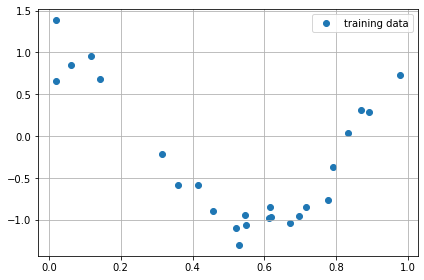

In [5]:
plt.scatter(x, y, label="training data")
plt.grid(), plt.legend(), plt.tight_layout();

Now that we got the **data**, let's find a **model** that fits it (accuratly).

# Linear regression model

The most simple model one can think of is a **linear regression model** with two fitting parameters ($a_0$ and $a_1$):

$$y(x)=a_0 + a_1* x $$

Note: For $N$ features (meaning `x` with $N$ columns) there would be $N$ pairs of fitting parameters ($a_0$ and $a_1$).

This **linear regression model**, as well as many other machine learning building block will be used from the **Scikit-learn** library

https://scikit-learn.org/

In [47]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

The `model` is there, but it's untrained, yet.

## `model.fit()`

In [48]:
model.fit(x, y);

... fitting the model is a simple *one-liner*.

Even better, **all Scikit-learn models** have the same basic interface with:
- `.fit(x_train, y_train)` for fitting / training
- `.predict(x_new)` predicting on new feature instances  

## `model.predict()`

In [49]:
some_x = np.array([0.2, 0.5, 0.9]).reshape((-1, 1))
some_x

array([[0.2],
       [0.5],
       [0.9]])

In [50]:
some_y = model.predict(some_x)
some_y

array([[ 0.08896829],
       [-0.27101419],
       [-0.75099082]])

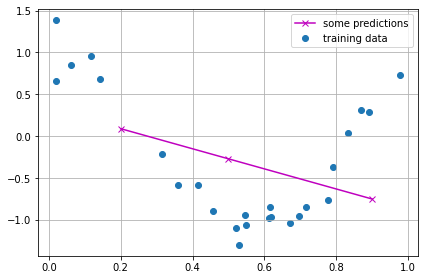

In [51]:
plt.scatter(x, y, label="training data")
plt.plot(some_x, some_y, "-xm", label="some predictions")
plt.grid(), plt.legend(), plt.tight_layout();

### Evaluation

- The **simple linear model** seems to be fitted correctly to the training data
- However, prediction accuracy isn't great
- The model **underfits** the data. For a more accurate fit the model isn't complex enough.

# Root mean squared error


Before improving the model further, we need a quantitative measure for the model's performance. There are two options:
- a loss function: smaller is better
- a utility function: bigger is better

For the linear regression model, the per sample error
$$ error = y_\text{pred} - y_\text{true}$$ can be plotted:

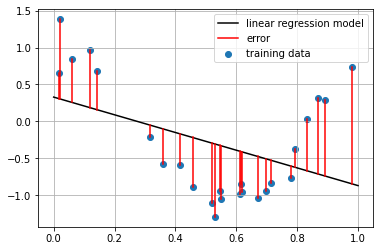

In [54]:
plt.scatter(x, y, label="training data")
plt.plot(x_pred, model.predict(x_pred), "k", label="linear regression model")
for xs, ys in zip(x, y):
    yp = next(iter(model.predict([xs])))
    plt.plot([xs, xs], [ys, yp], "r", label="error" if xs == x[0] else "")
plt.grid(), plt.legend();

In the following, we will be using the *root mean squared error* or RMSE, defined as
$$\text{RMSE}(y_\text{true}, y_\text{pred}) = \sqrt{\frac{1}{n_\text{samples}} \sum_{i=0}^{n_\text{samples} - 1} (y_\text{pred} - y_\text{true})^2}$$
*Scikit-learn* provides `mean_squared_error` ready to use. 

In [56]:
from sklearn.metrics import mean_squared_error

## Exercise

1. Write a wrapper function ``root_mean_squared_error(y_true, y_pred)`` that uses ``root_mean_squared_error`` and returns the ``RSME`` error

1. Compute the ``RSME`` for the trained model

1. Compute the ``RSME`` for a guess with all zeros



### Solutions

In [55]:
def root_mean_squared_error(y_true, y_pred, verbose=1):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    if verbose > 0:
        print("RMSE={:.2f}".format(rmse))
    return rmse

In [13]:
root_mean_squared_error(y, model.predict(x));

RMSE=0.71


That is significant error!

In [14]:
root_mean_squared_error(y, np.zeros_like(y));

RMSE=0.84


In [15]:
root_mean_squared_error(y, np.zeros(y.shape));

RMSE=0.84


# Polynominal features

We need a more powerful model. Let's stay with a linear regression model like
$$y(x)=a_0 + a_1* x $$
but add higher order features
$$y(x)=a_0 + a_1* x+ a_2*x^2 + ... + a_N*x^N$$

In [16]:
from sklearn.preprocessing import PolynomialFeatures

### Unterstanding **Polynominal features**

Example with 2 input features

In [17]:
df_2f = pd.DataFrame([[10, 0.9], [15, 0.7], [20, 0.8]], columns=["x0", "x1"])
df_2f

,x0,x1
0,10,0.9
1,15,0.7
2,20,0.8


In [18]:
pol = PolynomialFeatures(2)
pol_vals = pol.fit_transform(df_2f.values)
pd.DataFrame(pol_vals, columns=pol.get_feature_names())

,1,x0,x1,x0^2,x0 x1,x1^2
0,1.0,10.0,0.9,100.0,9.0,0.81
1,1.0,15.0,0.7,225.0,10.5,0.49
2,1.0,20.0,0.8,400.0,16.0,0.64


Example with 1 input feature

In [19]:
df_1f = df_2f[["x0"]]
pol = PolynomialFeatures(3)
pol_vals = pol.fit_transform(df_1f.values)
pd.DataFrame(pol_vals, columns=pol.get_feature_names())

,1,x0,x0^2,x0^3
0,1.0,10.0,100.0,1000.0
1,1.0,15.0,225.0,3375.0
2,1.0,20.0,400.0,8000.0


### Linear regression helper functions

In [57]:
def plot_lin_reg_fit(plot_train_data=True, plot_test_data=False, plot_ideal=False,
                     degrees=None):
    """
    Plots linear regression models with various polynominal degrees.
    """
    if degrees == None:
        degrees = [1, 5, 15]

    plt.figure(figsize=(10, 3))
    
    if plot_ideal:
        plt.plot(x_pred, ideal_func(x_pred), "-.k", label="ideal")

    if plot_train_data:
        plt.scatter(x, y, label="training data")

    if plot_test_data:
        plt.scatter(x_test, y_test, label="test data")

    for degree in degrees:
        model = Pipeline([("poly", PolynomialFeatures(degree=degree, include_bias=False)),
                            ("lin_reg", LinearRegression())])
        model.fit(x, y)
        y_pred = model.predict(x_pred)
        plt.plot(x_pred, y_pred, label="model degree "+str(degree))

    plt.grid(), plt.legend(), plt.ylim((-1.5, 1.5))

def plot_lin_rmse(plot_test_rmse=False, max_degree=15):
    """
    Plots RMSE of linear regression models with various polynominal degrees.
    """
    degrees = np.linspace(1, max_degree, max_degree, dtype=np.int8)
    rmse_train, rmse_test = [], []
    for degree in degrees:
        model = Pipeline([("poly", PolynomialFeatures(degree=degree, include_bias=False)),
                            ("lin_reg", LinearRegression())])
        model.fit(x, y)
        for rmse, xs, ys in zip([rmse_train, rmse_test],
                            [x, x_test],
                            [y, y_test]):
            rmse.append(root_mean_squared_error(ys, model.predict(xs), verbose=0))

    df = pd.DataFrame(np.column_stack([degrees, rmse_train, rmse_test]), columns=["model degree", "training", "test"])
    columns = ["training"]
    if plot_test_rmse:
        columns.append("test")
    df.plot.bar(x="model degree", y=columns, xlim=(1, max_degree), ylim=(0, 0.8), 
            figsize=(8, 3), grid=True, title="root mean squared error");

### Evaluating higher order models
The `plot_lin_reg_fit` and `plot_lin_rmse` helper functions support easy evaluation:

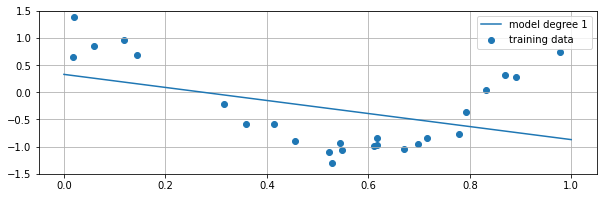

In [58]:
plot_lin_reg_fit(degrees=[1])

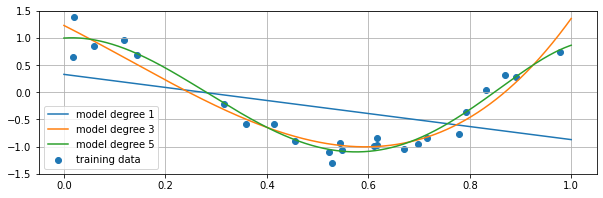

In [59]:
plot_lin_reg_fit(degrees=[1, 3, 5])

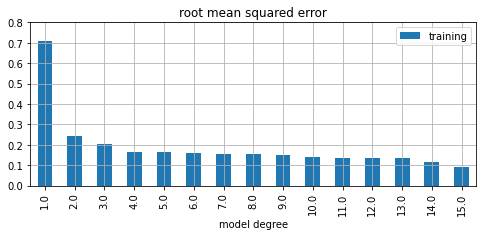

In [60]:
plot_lin_rmse()

The RSME continous to decrease with higher model degree. 

But wait! Let's quickly reconfirm the "high-order models"...

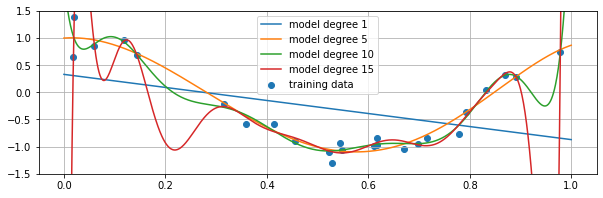

In [61]:
plot_lin_reg_fit(degrees=[1, 5, 10, 15])

# Generalization problem

The RSME of `model degree 10` is better than `model degree 5` and `model degree 15` is even better.

However, judging the models qualitatively doesn't quite confirm the RSME numbers.

Luckily, we didn't train the models on the entire data set. Instead, we've taken half of the data set apart as **test set**. That is fresh data, the model hasn't seen before:

In [25]:
len(x), len(x_test)

(25, 25)

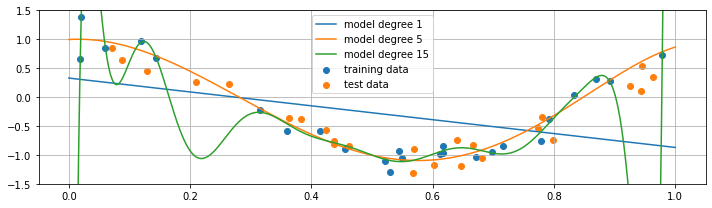

In [26]:
plot_lin_reg_fit(plot_test_data=True, degrees=[1, 5, 15])

We can calculate the RMSE on the **test set** separately:

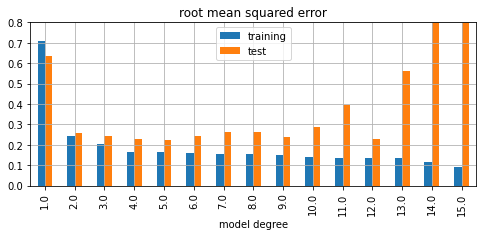

In [27]:
plot_lin_rmse(plot_test_rmse=True)

*Test RSME* being far worse than *training RSME* is a clear evidence of **overfitting**.

- Overfitting models don't **generalize** well. Instead they **memorize** the training data. 

- The common root cause of overfitting is **too few training data** applied to a **too complex model**.

- **Regularization** helps to avoids overfitting of complex models.

The model is **underfitting** if both *RSME's* are bad. There are various potential root causes: 
- Too simple model,
- labels unpredictable from features (e.g. probability of rain isn't accuratly predictable given the day of the week) 

Plotting the **best fit model** along with `ideal` (the function that generated the data set) shows:
- the **fit** is quite good
- noise is not predictable

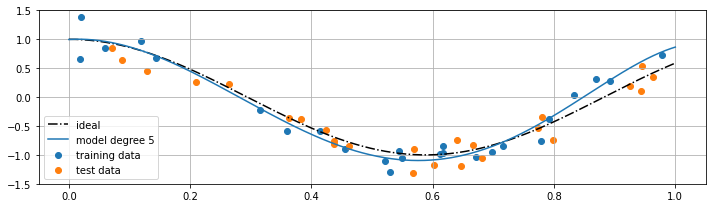

In [28]:
plot_lin_reg_fit(plot_test_data=True, plot_ideal=True, degrees=[5])

# Decision tree model

Let's try a very different type of model, a **Decision tree model** on the same data.

The interface is identical to the `LinearRegression` model:

In [29]:
from sklearn.tree import DecisionTreeRegressor
model = DecisionTreeRegressor()
model.fit(x, y)
some_x = np.array([0.2, 0.5, 0.9]).reshape((-1, 1))
model.predict(some_x)

array([ 0.67841312, -1.10043088,  0.28604448])

### Decision tree helper functions

In [30]:
from sklearn import tree

def plot_tree_fit(plot_train_data=True, plot_test_data=False, plot_tree=False, 
                  max_depth=2, min_samples_leaf=None):
    """
    Plots the fitted function of various decision tree models.
    """
    if min_samples_leaf == None:
        min_samples_leaf = [2]

    plt.figure(figsize=(10, 3))
    
    if plot_train_data:
        plt.scatter(x, y, label="training data")

    if plot_test_data:
        plt.scatter(x_test, y_test, label="test data")

    for min_samples in min_samples_leaf:
        model = DecisionTreeRegressor(max_depth=max_depth, min_samples_leaf=min_samples)
        model.fit(x, y);
        y_pred = model.predict(x_pred)
        plt.plot(x_pred, y_pred, label="min samples per leaf = "+str(min_samples))

    plt.grid(), plt.legend(), plt.ylim((-1.5, 1.5))
    plt.tight_layout()

    if plot_tree:
        plt.figure(figsize=(8,7))
        tree.plot_tree(model)


def plot_tree_rmse(plot_test_rmse=True):
    """
    Plots RMSE of various decision tree models.
    """
    MAX_LEAF = 15
    min_samples_leaf = np.linspace(MAX_LEAF, 1, MAX_LEAF, dtype=np.int8)
    rmse_train, rmse_test = [], []
    for min_samples in min_samples_leaf:
        model = DecisionTreeRegressor(max_depth=100, min_samples_leaf=min_samples)
        model.fit(x, y);
        for rmse, xs, ys in zip([rmse_train, rmse_test],
                            [x, x_test],
                            [y, y_test]):
            rmse.append(root_mean_squared_error(ys, model.predict(xs), verbose=0))

    df = pd.DataFrame(np.column_stack([min_samples_leaf, rmse_train, rmse_test]), 
                      columns=["min samples per leaf", "training", "test"])
    columns = ["training"]
    if plot_test_rmse:
        columns.append("test")
    df.plot.bar(x="min samples per leaf", y=columns, xlim=(1, MAX_LEAF), ylim=(0, 0.8), 
            figsize=(8, 3), grid=True, title="root mean squared error");


### Decision tree evaluation

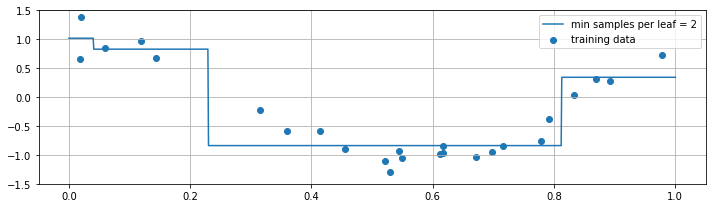

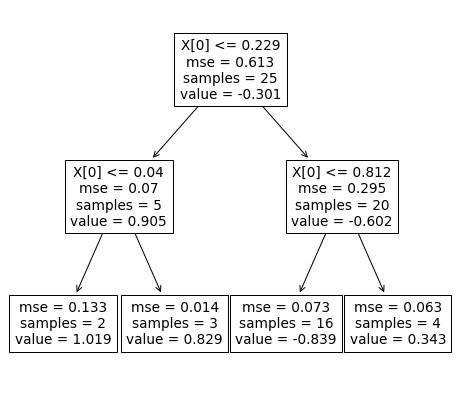

In [31]:
plot_tree_fit(max_depth=2, min_samples_leaf=[2], plot_tree=True)

Both parameters, `max_depth` and `min_samples_leaf` can be used for **regularization**

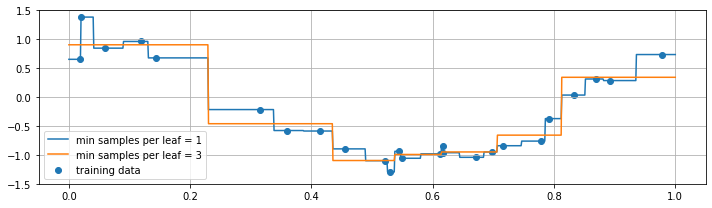

In [32]:
plot_tree_fit(max_depth=10, min_samples_leaf=[1, 3])

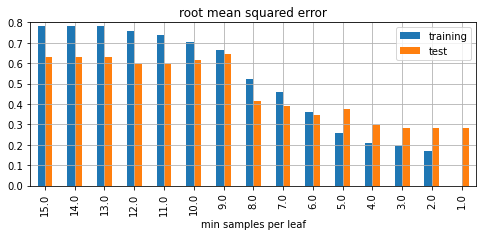

In [33]:
plot_tree_rmse()

The "1 sample per leaf" model is clearly overfitting:

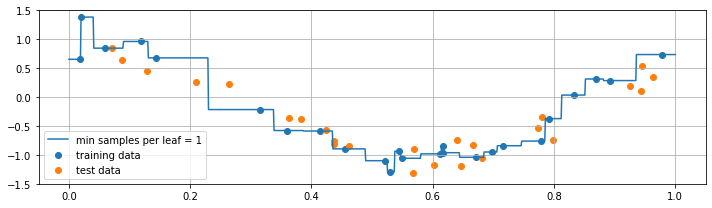

In [34]:
plot_tree_fit(max_depth=10, min_samples_leaf=[1], plot_test_data=True)

"3 samples per leaf" seem to be the *best fit model*: 

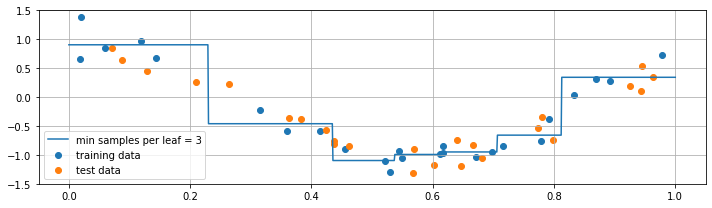

In [35]:
plot_tree_fit(max_depth=10, min_samples_leaf=[3], plot_test_data=True)

## Decision tree model summary
- non-linear models
- decision rules are derived from the training data
- usable as 'white box models', because the rules allow easy interpretetation
- more details at https://scikit-learn.org/stable/modules/tree.html